# cGAN: Theory

For notes on the standard GAN please refer to the [[GAN Notebook]](https://github.com/udeepam/gan/blob/master/notebooks/gan.ipynb).

The conditional GAN is very similar to the standard GAN except now both the discriminator $D$ and generator $G$ are conditioned on some extra information $\mathbf{y}$ such as class labels. 

### The Objective Function
The objective function of the conditional GAN is

$$\underset{G}{\text{min }}\underset{D}{\text{max }}V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x}\mid\mathbf{y})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z}\mid\mathbf{y})\big)\Big)\bigg]$$

### References
Original conditional GAN paper: https://arxiv.org/abs/1411.1784

# cGAN: Code

**Resources**<br>
PyTorch-GAN: https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
import torch.utils.data as data_utils

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)

%matplotlib inline

## Load MNIST Dataset

In [2]:
# Download MNIST dataset, preprocess and save locally as .npz file
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import MNIST
# # 60000 tuples with 1x28x28 image and corresponding label
# data = MNIST('../data', 
#              train=True, 
#              download=True,
#              transform = transforms.Compose([transforms.ToTensor()]))
# # Split data into images and labels
# x_train = data.train_data
# y_train = data.train_labels
# # Scale images from [0,255] to [-1,+1]
# x_train = ((x_train.float() / 255) - 0.5) * 2
# # Save as .npz
# np.savez_compressed('../data/mnist', 
#                     a=x_train,
#                     b=y_train)

In [3]:
# Load MNIST data locally
data = np.load('../data/mnist.npz')
x_train = torch.Tensor(data['a'])
y_train = torch.Tensor(data['b'])
n_classes = len(np.unique(y_train))

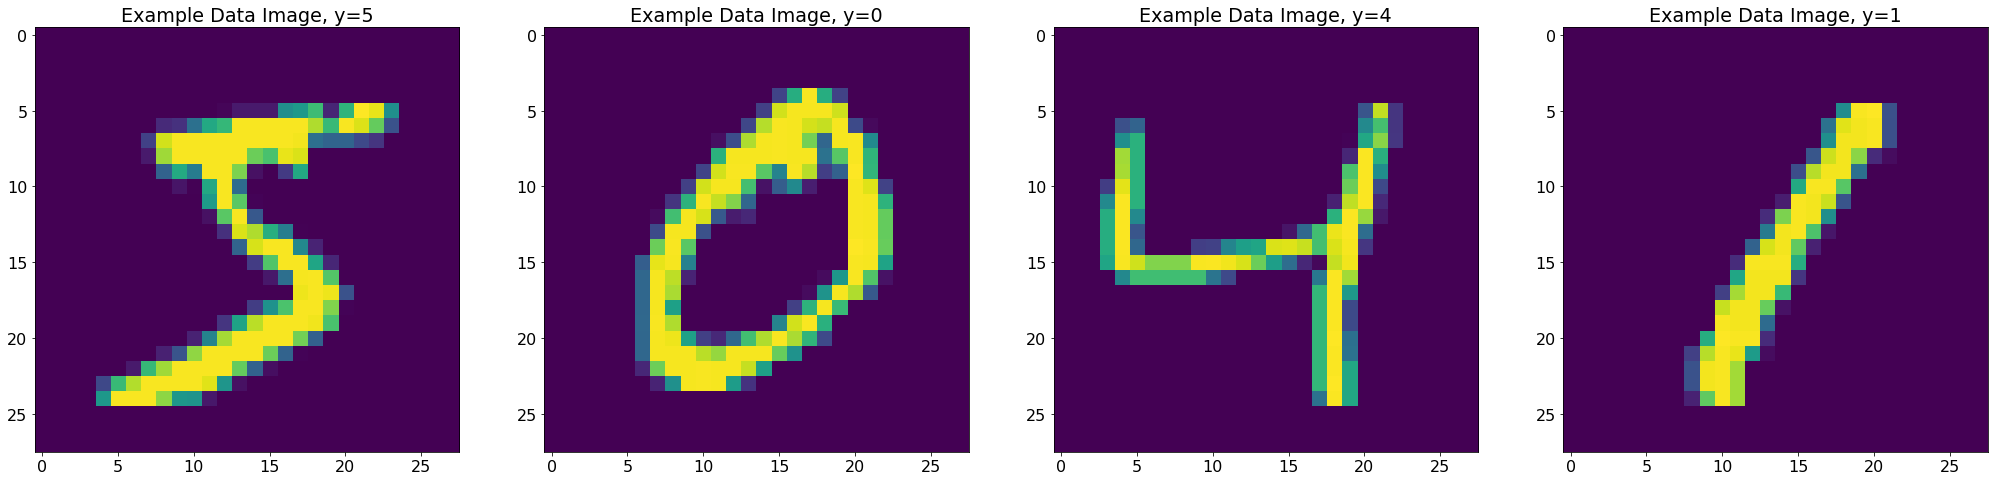

In [4]:
# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,4, figsize=(35,35))
imx, imy = (28,28)
labels   = [0,1,2,3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx,imy))
    ax.set_title("Example Data Image, y="+str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=-1, vmax=1)
plt.show()

## Models

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_shape, n_classes, output_shape):
        """
        Generator Model.
        
        Arguments:
        ----------
        latent_shape : `int`
            Dimensionality of the latent space. (Default=100)
        n_classes : `int`
            Number of classes. (Default=10)
        output_shape : `int`
            Flattened size of image. (Default=784)
        """
        super(Generator, self).__init__()
        
        # Embedding to one-hot-encode the labels 
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        def block(in_shape, out_shape, normalize=True):
            layers = [nn.Linear(in_shape, out_shape)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_shape, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers        
        
        self.model = nn.Sequential(*block(latent_shape+n_classes, 128, normalize=False),
                                   *block(128, 256),
                                   *block(256, 512),
                                   *block(512, 1024),
                                   nn.Linear(1024, output_shape),
                                   nn.Tanh())

    def forward(self, z, y):
        # Concatenate noise and label embedding to produce input
        g_input = torch.cat((z, self.label_emb(y)), -1)        
        return self.model(g_input)     

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_shape, n_classes):
        """
        Discriminator Model.
        
        Arguments:
        ----------
        img_shape : `int`
            Flattened size of image. (Default=784)
        n_classes : `int`
            Number of classes. (Default=10)            
        """        
        super(Discriminator, self).__init__()
        
        # Embedding to one-hot-encode the labels 
        self.label_emb = nn.Embedding(n_classes, n_classes)        
   
        self.model = nn.Sequential(nn.Linear(img_shape+n_classes, 1024),
                                   nn.Dropout(0.4),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(1024, 512),
                                   nn.Dropout(0.4),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(512, 256),
                                   nn.Dropout(0.4),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(256, 1),
                                   nn.Sigmoid())        

    def forward(self, x, y):
        x_flat = x.view(x.size(0), -1) 
        # Concatenate image and label embedding to produce input        
        d_input = torch.cat((x_flat, self.label_emb(y)), -1)              
        return self.model(d_input)

## Training

In [7]:
# Hyperparameters
z_dim  = 100
epochs = 200
batch_size = 256
learning_rate = 2e-4

In [8]:
# Create DatatLoader 
dataset    = data_utils.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

# Loss function: we use the binary cross entropy loss
adversarial_loss = torch.nn.BCELoss()

# Initialize discriminator and generator
discriminator = Discriminator(np.prod(x_train[0].shape), n_classes)
generator     = Generator(z_dim, n_classes, np.prod(x_train[0].shape))

# Optimisers
optimiser_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimiser_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)

# Send to GPU if available
discriminator.to(device)
generator.to(device)

print("Device: ", device)
print(discriminator)
print(generator)

Device:  cuda
Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope

In [9]:
# Training
measures = defaultdict(list)
start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    
    batch_loss_g = 0  
    batch_loss_d = 0  
    for i, (X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.type(torch.LongTensor).to(device)
        # Generate random labels
        gen_y = torch.LongTensor(np.random.randint(0, n_classes, X.shape[0])).to(device)
        # Adversarial ground truths
        y_true = torch.ones(X.size(0), 1, dtype=torch.float).to(device)
        y_fake = torch.zeros(X.size(0), 1, dtype=torch.float).to(device)           
        
        # Train Generator
        #----------------
        discriminator.eval()
        generator.train()              
        
        # Zero accumulated gradients
        generator.zero_grad()
        
        # Sample noise as generator input
        z = torch.FloatTensor(np.random.normal(0, 1, (X.shape[0], z_dim))).to(device)  
        # Generate a batch of images
        gen_X = generator(z, gen_y)
        
        # Calculate loss
        g_loss = adversarial_loss(discriminator(gen_X, gen_y), y_true)
        # Backpropogation: calculating gradients
        g_loss.backward()
        # Update parameters of generator
        optimiser_G.step()            
    
        # Train Discriminator
        #--------------------
        discriminator.train()
        generator.eval()     
        
        # Zero accumulated gradients
        discriminator.zero_grad()  

        # Calculate loss           
        true_loss = adversarial_loss(discriminator(X, y), y_true)
        fake_loss = adversarial_loss(discriminator(gen_X.detach(), gen_y), y_fake)
        d_loss = true_loss + fake_loss
        # Backpropogation: calculating gradients
        d_loss.backward()
        # Update parameters of discriminator
        optimiser_D.step()       
            
        # Save loss per batch
        batch_loss_g += g_loss.item()*X.size(0)          
        batch_loss_d += d_loss.item()*X.size(0)            
    # Save losses per epoch
    measures['total_loss_g'].append(batch_loss_g / len(dataloader.dataset))        
    measures['total_loss_d'].append(batch_loss_d / len(dataloader.dataset))   
    
    # Save images from each class produced every epoch
    if epoch ==0 or (epoch+1)%4==0:    
        z = torch.FloatTensor(np.random.normal(0, 1, (n_classes, z_dim))).to(device) 
        labels = torch.LongTensor(np.arange(0,n_classes)).to(device)
        gen_X = generator(z, labels)  
        measures['images'].append(gen_X.detach().cpu().numpy())     
    
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "D Loss: {:.4f}...".format(measures['total_loss_d'][-1]),
          "G Loss: {:.4f}...".format(measures['total_loss_g'][-1]),
          "Time Taken: {:,.4f} seconds".format(time.time()-epoch_start_time))    
    
print("Total Time Taken: {:,.4f} seconds".format(time.time()-start_time))

Epoch: 1/200... D Loss: 0.3394... G Loss: 2.9235... Time Taken: 6.2854 seconds
Epoch: 2/200... D Loss: 0.4482... G Loss: 10.2580... Time Taken: 3.1812 seconds
Epoch: 3/200... D Loss: 0.3018... G Loss: 10.4956... Time Taken: 3.1048 seconds
Epoch: 4/200... D Loss: 0.4235... G Loss: 4.0124... Time Taken: 3.1571 seconds
Epoch: 5/200... D Loss: 0.5351... G Loss: 2.9572... Time Taken: 3.2828 seconds
Epoch: 6/200... D Loss: 0.3724... G Loss: 3.5147... Time Taken: 3.2332 seconds
Epoch: 7/200... D Loss: 0.3275... G Loss: 3.8165... Time Taken: 3.0805 seconds
Epoch: 8/200... D Loss: 0.2947... G Loss: 3.7351... Time Taken: 3.1677 seconds
Epoch: 9/200... D Loss: 0.2740... G Loss: 3.9482... Time Taken: 3.1409 seconds
Epoch: 10/200... D Loss: 0.2110... G Loss: 4.4724... Time Taken: 3.3240 seconds
Epoch: 11/200... D Loss: 0.3014... G Loss: 3.9227... Time Taken: 3.7821 seconds
Epoch: 12/200... D Loss: 0.2776... G Loss: 4.0669... Time Taken: 3.7180 seconds
Epoch: 13/200... D Loss: 0.2684... G Loss: 3.87

Epoch: 104/200... D Loss: 1.1576... G Loss: 1.1058... Time Taken: 3.1541 seconds
Epoch: 105/200... D Loss: 1.1440... G Loss: 1.0926... Time Taken: 3.0875 seconds
Epoch: 106/200... D Loss: 1.1696... G Loss: 1.0905... Time Taken: 3.2193 seconds
Epoch: 107/200... D Loss: 1.1442... G Loss: 1.1223... Time Taken: 3.2862 seconds
Epoch: 108/200... D Loss: 1.1526... G Loss: 1.0866... Time Taken: 3.0728 seconds
Epoch: 109/200... D Loss: 1.1595... G Loss: 1.0947... Time Taken: 2.9548 seconds
Epoch: 110/200... D Loss: 1.1676... G Loss: 1.0839... Time Taken: 2.9900 seconds
Epoch: 111/200... D Loss: 1.1751... G Loss: 1.0673... Time Taken: 3.2387 seconds
Epoch: 112/200... D Loss: 1.1569... G Loss: 1.0936... Time Taken: 3.5789 seconds
Epoch: 113/200... D Loss: 1.1856... G Loss: 1.0686... Time Taken: 3.5855 seconds
Epoch: 114/200... D Loss: 1.1698... G Loss: 1.0883... Time Taken: 3.2398 seconds
Epoch: 115/200... D Loss: 1.1711... G Loss: 1.0944... Time Taken: 3.2749 seconds
Epoch: 116/200... D Loss: 1.

## Results

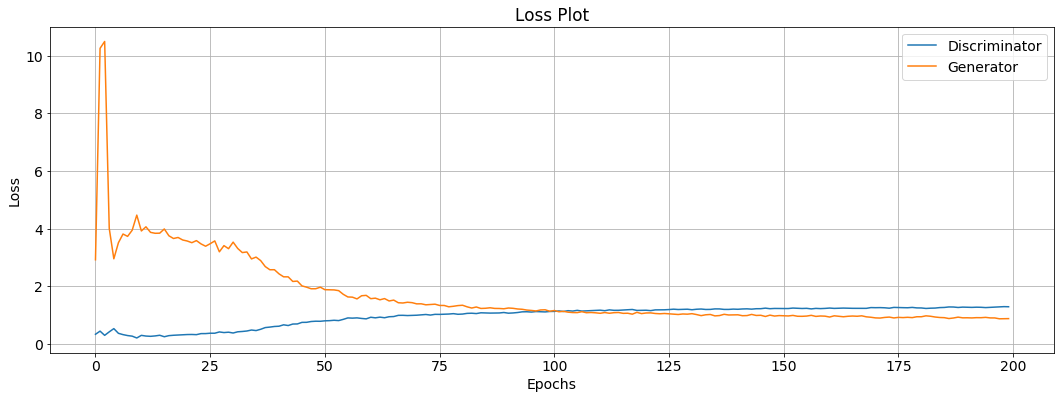

In [10]:
# Plot loss
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(18,6))
plt.plot(measures['total_loss_d'], label='Discriminator')
plt.plot(measures['total_loss_g'], label='Generator')
plt.title('Loss Plot')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

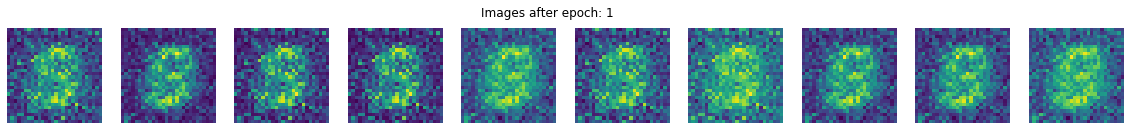

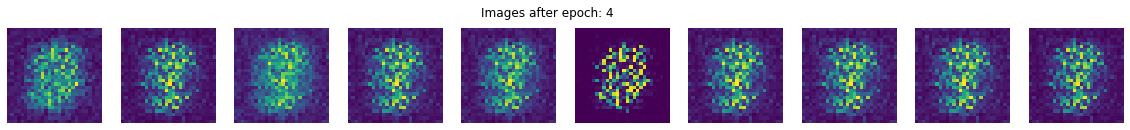

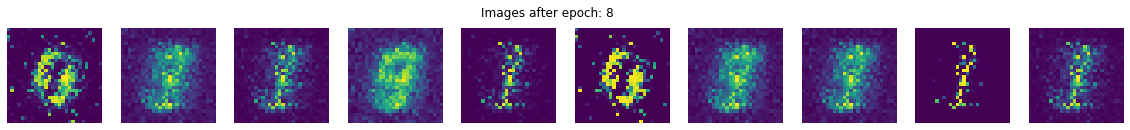

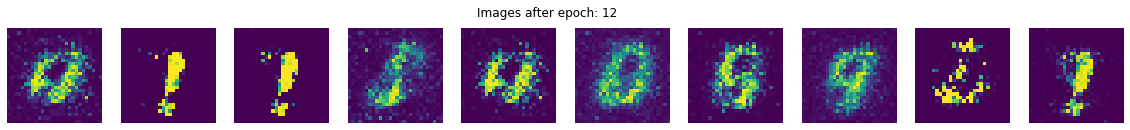

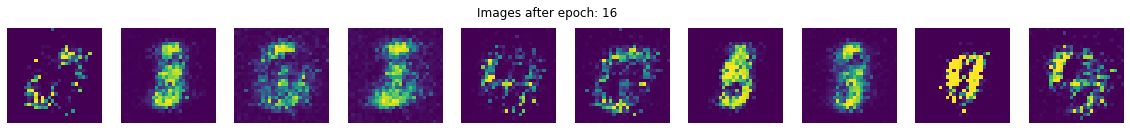

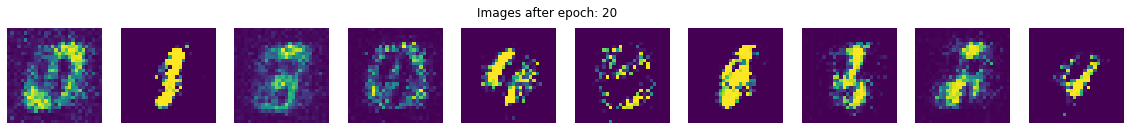

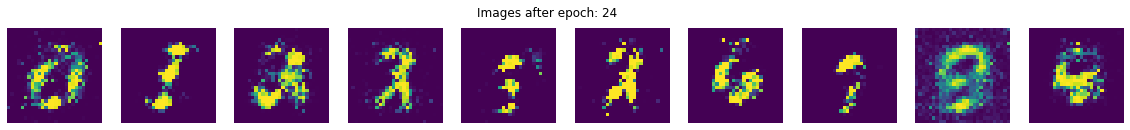

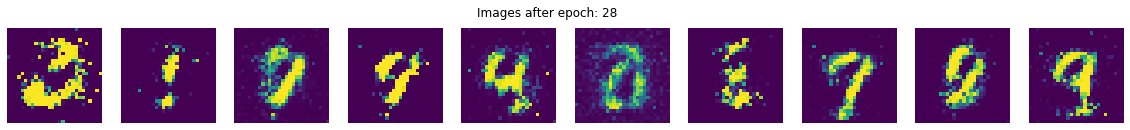

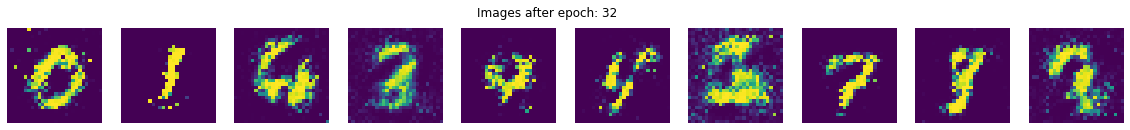

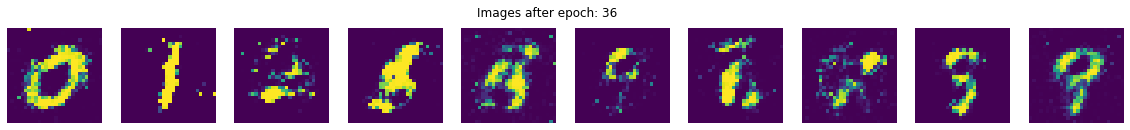

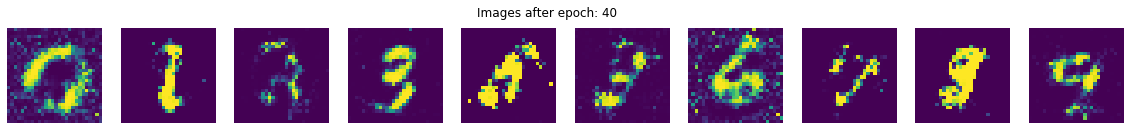

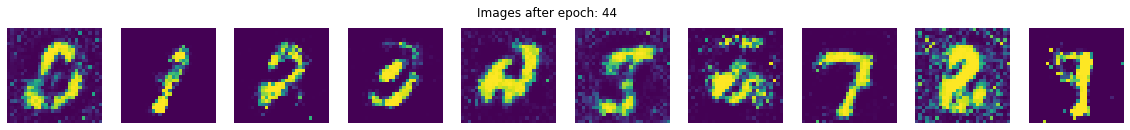

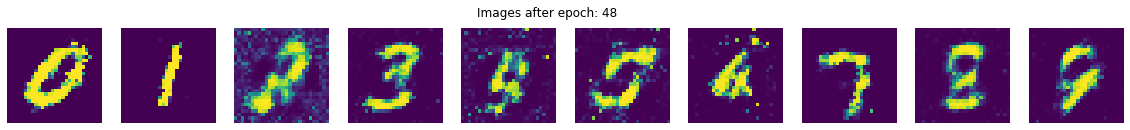

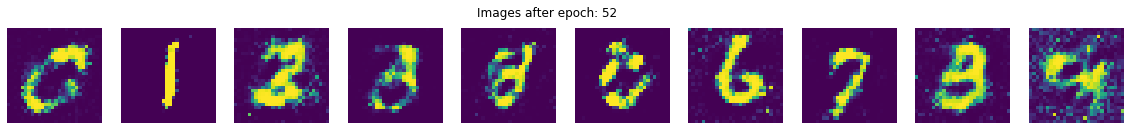

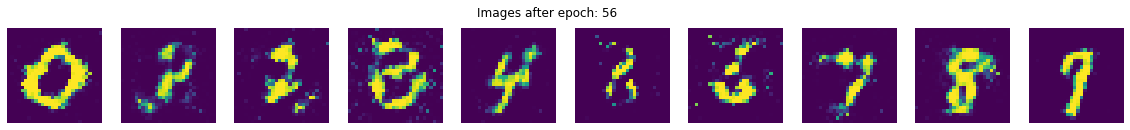

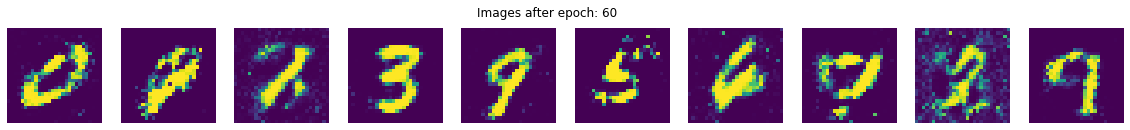

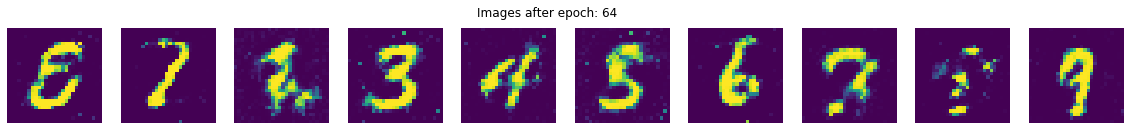

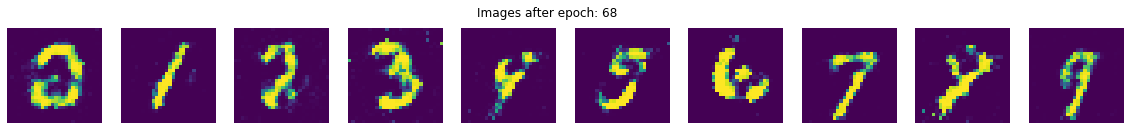

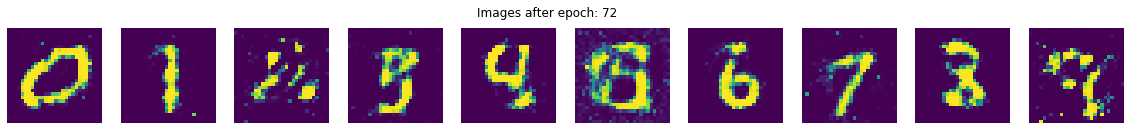

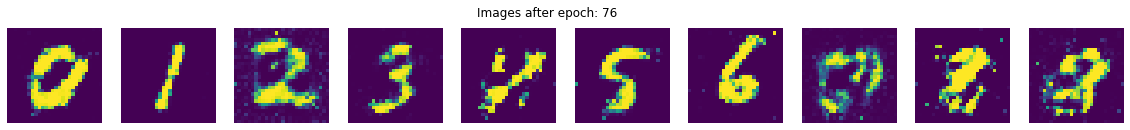

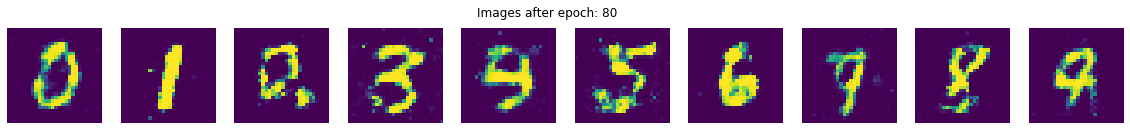

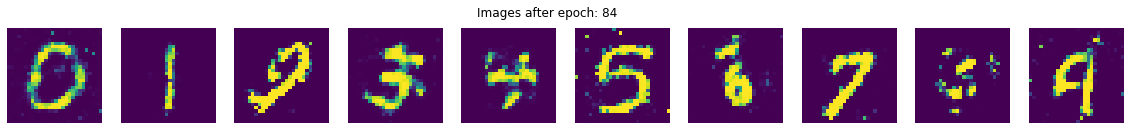

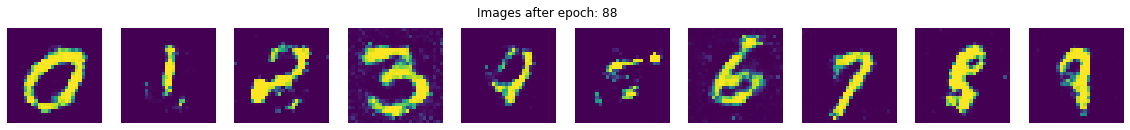

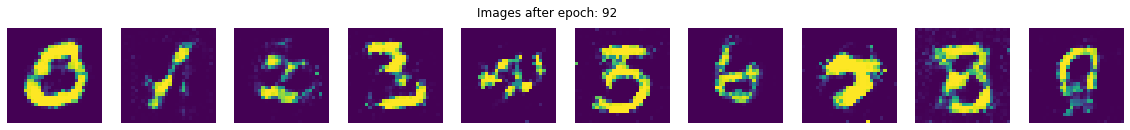

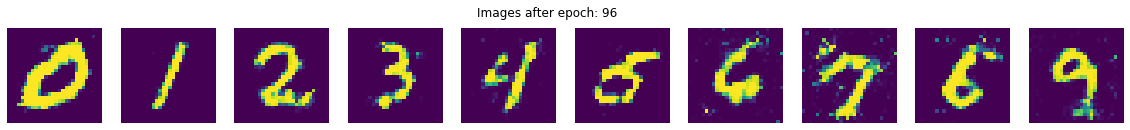

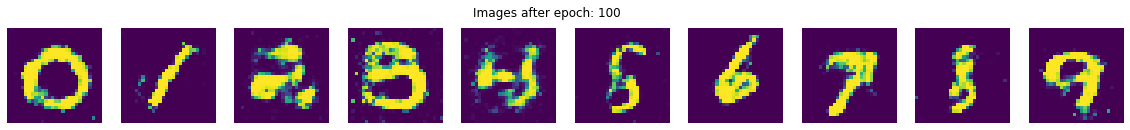

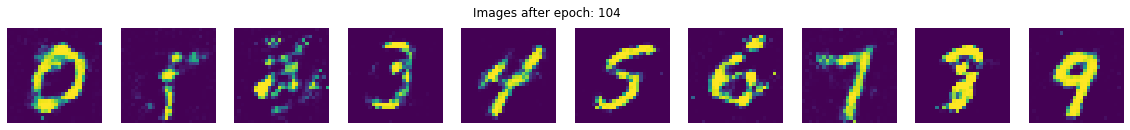

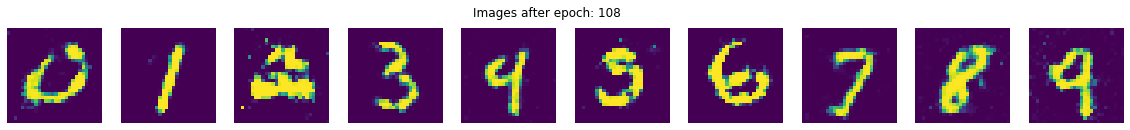

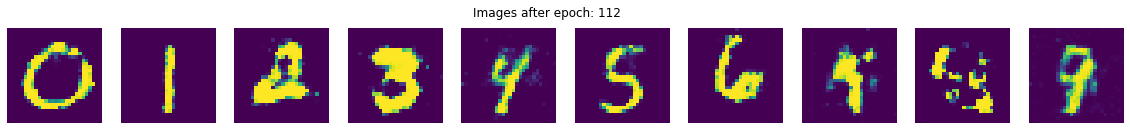

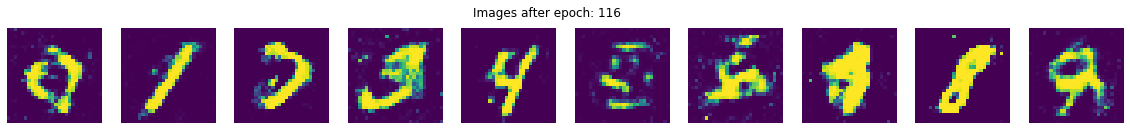

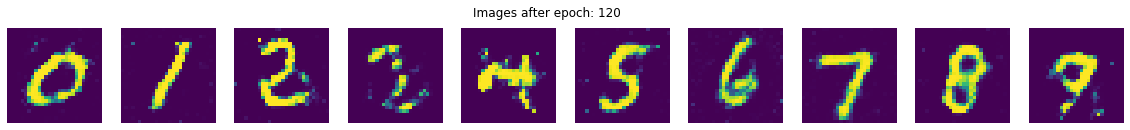

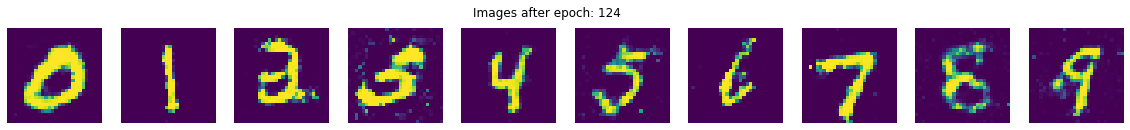

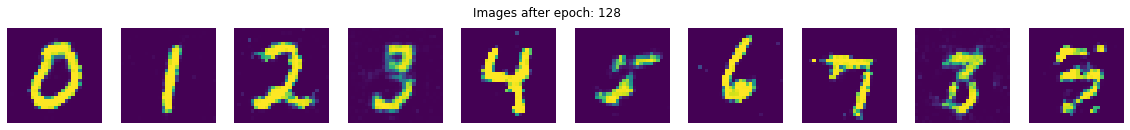

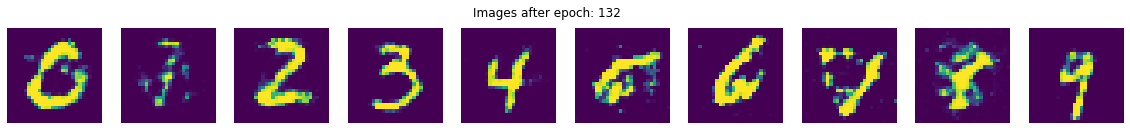

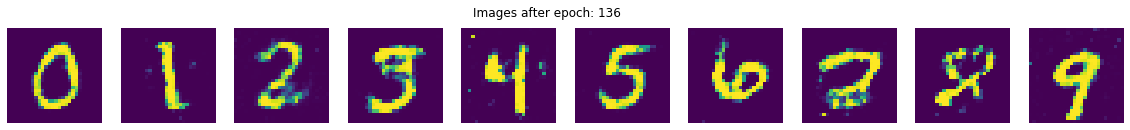

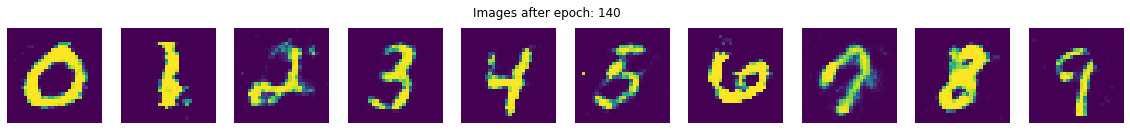

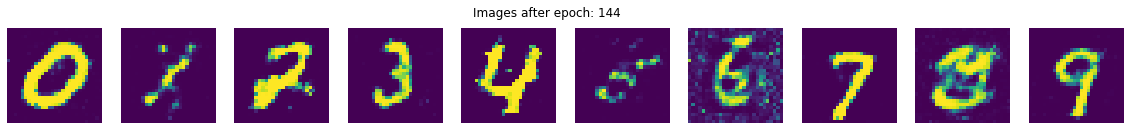

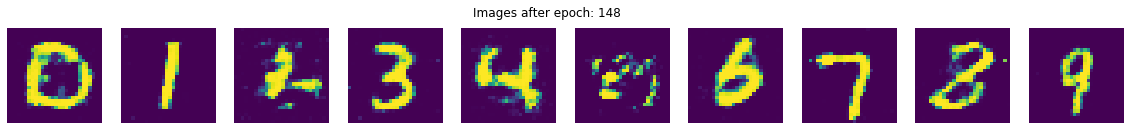

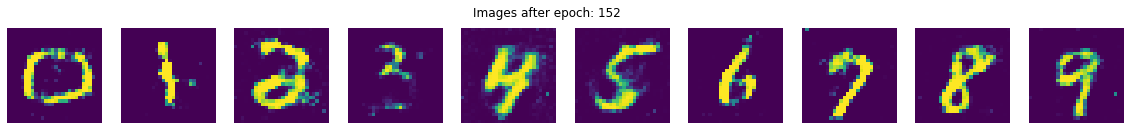

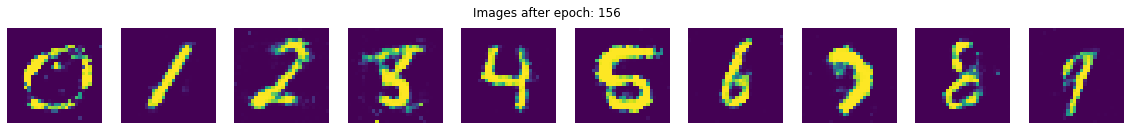

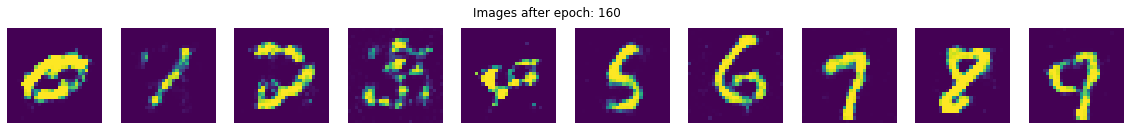

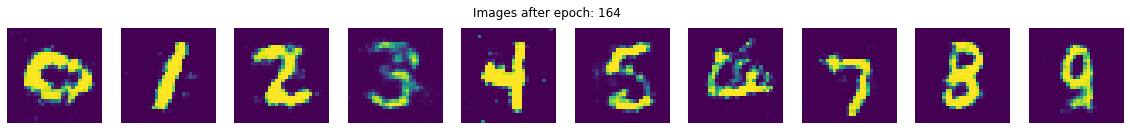

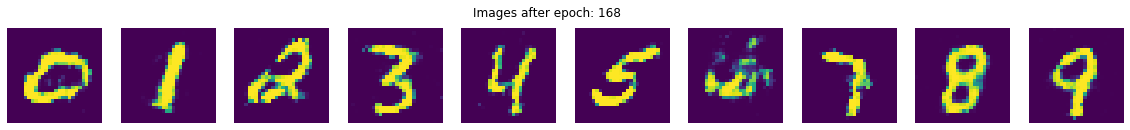

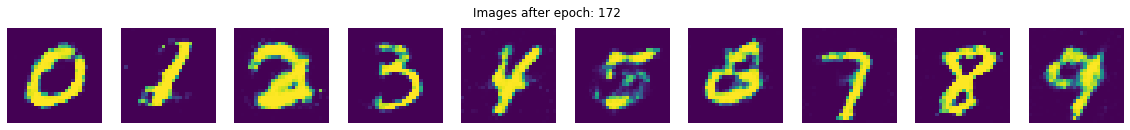

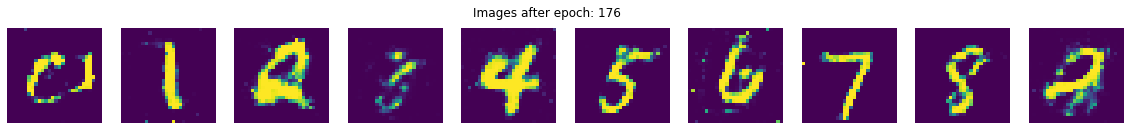

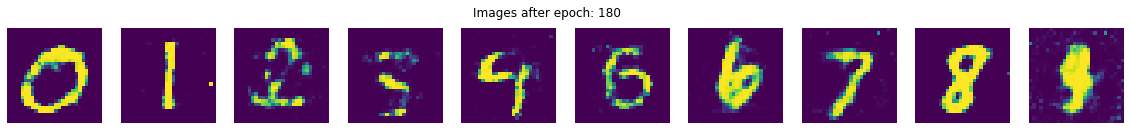

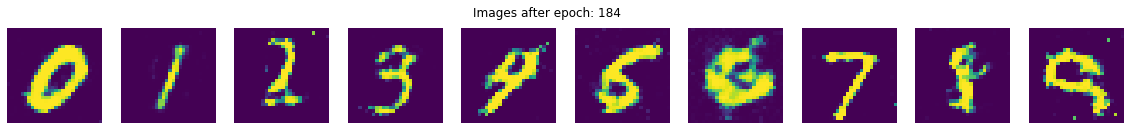

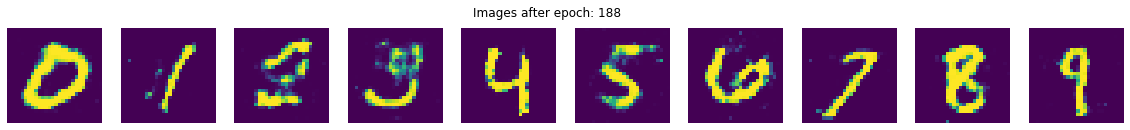

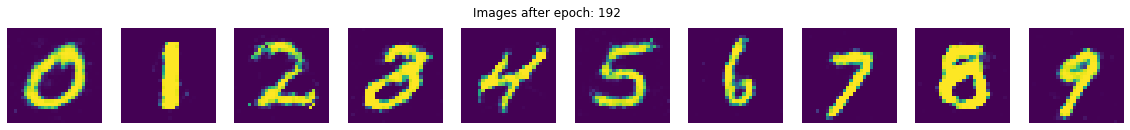

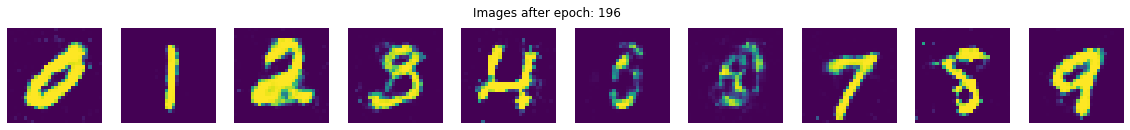

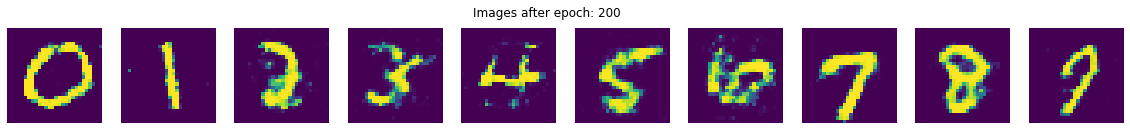

In [11]:
# Plot images generated by Generator
plt.rcParams.update({'font.size': 10})
imx, imy = (28,28)
for i, imgs in enumerate(measures['images']):
    fig, axs = plt.subplots(1, n_classes, figsize=(20,2)) 
    for j, img in enumerate(imgs):
        visual = np.reshape(img, (imx,imy))
        axs[j].imshow(visual)
        axs[j].axis('off')
    label = i+1 if i==0 else 4*i
    plt.suptitle('Images after epoch: %s' %label)
    plt.show()